In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
import tqdm
import ultralytics

In [2]:
CLASS_NAMES = ['aeroplane' ,'bicycle' ,'bird' ,'boat' ,'bottle' ,
               'bus' ,'car' ,'cat' ,'chair' ,'cow' ,'diningtable' ,
               'dog' ,'horse' ,'motorbike' ,'person' ,'pottedplant' ,
               'sheep' ,'sofa' ,'train' ,'tvmonitor']

COLORS = [
    [255, 0, 0],        # Красный
    [0, 255, 0],        # Зеленый
    [0, 0, 255],        # Синий
    [255, 255, 0],      # Желтый
    [255, 0, 255],      # Фиолетовый
    [0, 255, 255],      # Бирюзовый
    [128, 0, 0],        # Темно-красный
    [0, 128, 0],        # Темно-зеленый
    [0, 0, 128],        # Темно-синий
    [128, 128, 0],      # Темно-желтый
    [128, 0, 128],      # Темно-фиолетовый
    [0, 128, 128],      # Темно-бирюзовый
    [67, 67, 67],    # Серый
    [255, 165, 0],      # Оранжевый
    [67, 0, 130],    # Розовый
    [139, 69, 19],      # Коричневый
    [169, 169, 169],    # Темно-серый
    [12, 138, 14],    # Светло-зеленый
    [255, 20, 147],     # Гелиотроп
    [255, 99, 71]       # Темно-красный
] #, dtype=np.uint8


In [7]:
!ls ../runs/warmup/orig/nano

wm_0  wm_10  wm_3  wm_6


In [3]:
experiments = ['warmup']
training_data = ['GD_train','GD_train_val','orig']
models = ['nano', 'small', 'medium', 'large', 'extra_large']
warmup = ['wm_0', 'wm_3', 'wm_6', 'wm_10']
data_split = ['train', 'test']
metrics = ['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2']

experiments_settings = [experiments, training_data, models, data_split]

def get_plot_data(experiments_settings, query):
    """
    experiments_settings (tuple) - все комбинации экспериментов в правильном порядке
    query - запрос в формате tuple; 
        первое значение (array) - список комбинаций экспериментов
        второе значение (bool) - нужно выводить на одном графике или на разных
    """
    # result = []
    main_path = '../runs'
    all_paths = get_all_paths([([(main_path, '')], '')], query)
    all_paths = fill_endings(all_paths)
    data = get_data(all_paths)
    return all_paths, data

    

def get_all_paths(paths, query):
    new_paths = []
    current_split = query[0]
    query = query[1:] if len(query) > 1 else None

    if current_split[1] == 0:
        for split_dir in current_split[0]:
            for plot_data_path in paths:
                new_paths.append(([(f'{x[0]}/{split_dir}', f'{x[1]}') for x in plot_data_path[0]], 
                                  f'{plot_data_path[1]} {split_dir}'))

    elif current_split[1] == 1:
        for plot_data_path in paths:
            extended_plot_data = []
            for split_dir in current_split[0]:
                extended_plot_data.extend([(f'{x[0]}/{split_dir}', f'{x[1]} {split_dir}') for x in plot_data_path[0]])
            new_paths.append((extended_plot_data, plot_data_path[1]))

    if query is None:
        return new_paths
    else:
        return get_all_paths(new_paths, query)


def fill_endings(paths):
    new_paths = []
    for plot_data_path in (paths):
        new_paths.append(([], plot_data_path[1]))
        for data_path in plot_data_path[0]:
            if data_path[0].endswith('train'):
                new_data_path = f'{data_path[0]}/results.csv'
            else:
                new_data_path = f'{data_path[0]}/results.pickle'
            new_paths[-1][0].append((new_data_path, data_path[1]))
    return new_paths


def get_data(paths):
    all_data = []
    for plot_data_path in (paths):
        all_data.append(([], plot_data_path[1]))
        for data_path in plot_data_path[0]:
            if data_path[0].endswith('.csv'):
                data = prepare_df(data_path[0])
            else:
                data = pickle.load(open(data_path[0], "rb"))
            all_data[-1][0].append((data, data_path[1]))
    return all_data
            

def prepare_df(path):
    df = pd.read_csv(path)
    df.columns = [x.split(' ')[-1] for x in df.columns]
    return df          


In [4]:
### PLOTS

def get_metric_df(dataframe, metric_name):
    metric = dataframe[metric_name]
    metric = metric.astype('float64')[:30]
    epoch = dataframe['epoch'][:30]
    epoch = epoch.astype('int64')
    return (epoch, metric), ('epoch', metric_name)

def get_pickle(pickle_data, metric_name, index):
    metric = getattr(pickle_data, metric_name)
    return ([index], [metric]), ('index', metric_name)


def plot_results_metrics(results, metric_config, dim = (8,5)):
    n_rows = len(results)
    
    fig, axis = plt.subplots(nrows = n_rows, ncols = 1, figsize = (dim[0], dim[1] * n_rows))
    plt.subplots_adjust(wspace= 0.4, hspace=0.4)

    if isinstance(axis, np.ndarray) is False:
        axis = np.array([axis])

    for ax, plot_res in zip(axis, results):
        title = plot_res[1]
        
        for index_res, res in enumerate(plot_res[0]):

            for index_metric, config in enumerate(metric_config):
                metric_func, metric_name, plot_type = config
                if isinstance(res[0], ultralytics.utils.metrics.Metric):
                    plot_data = metric_func(res[0], metric_name, index_res)
                else:
                    plot_data = metric_func(res[0], metric_name)

                lenestyles= ['-', '--', '-.', ':']
                label = f'{res[1]} {metric_name}'
            
                if plot_type == 'plot':
                    ax.plot(*plot_data[0], label = label, linestyle=lenestyles[index_metric])
                elif plot_type == 'scatter':
                    ax.scatter(*plot_data[0], label = label)


                ax.set_xlabel(plot_data[1][0], fontsize = 24,)
                
        ax.legend(fontsize = 18, loc='right', borderaxespad=-17) 
        ax.grid(which = "major", linewidth = 1)
        ax.xaxis.set_tick_params(labelsize=18)
        ax.yaxis.set_tick_params(labelsize=18)
        ax.set_ylabel('Metrics', fontsize = 24)
        ax.set_title(title, fontsize = 30)

    plt.show()


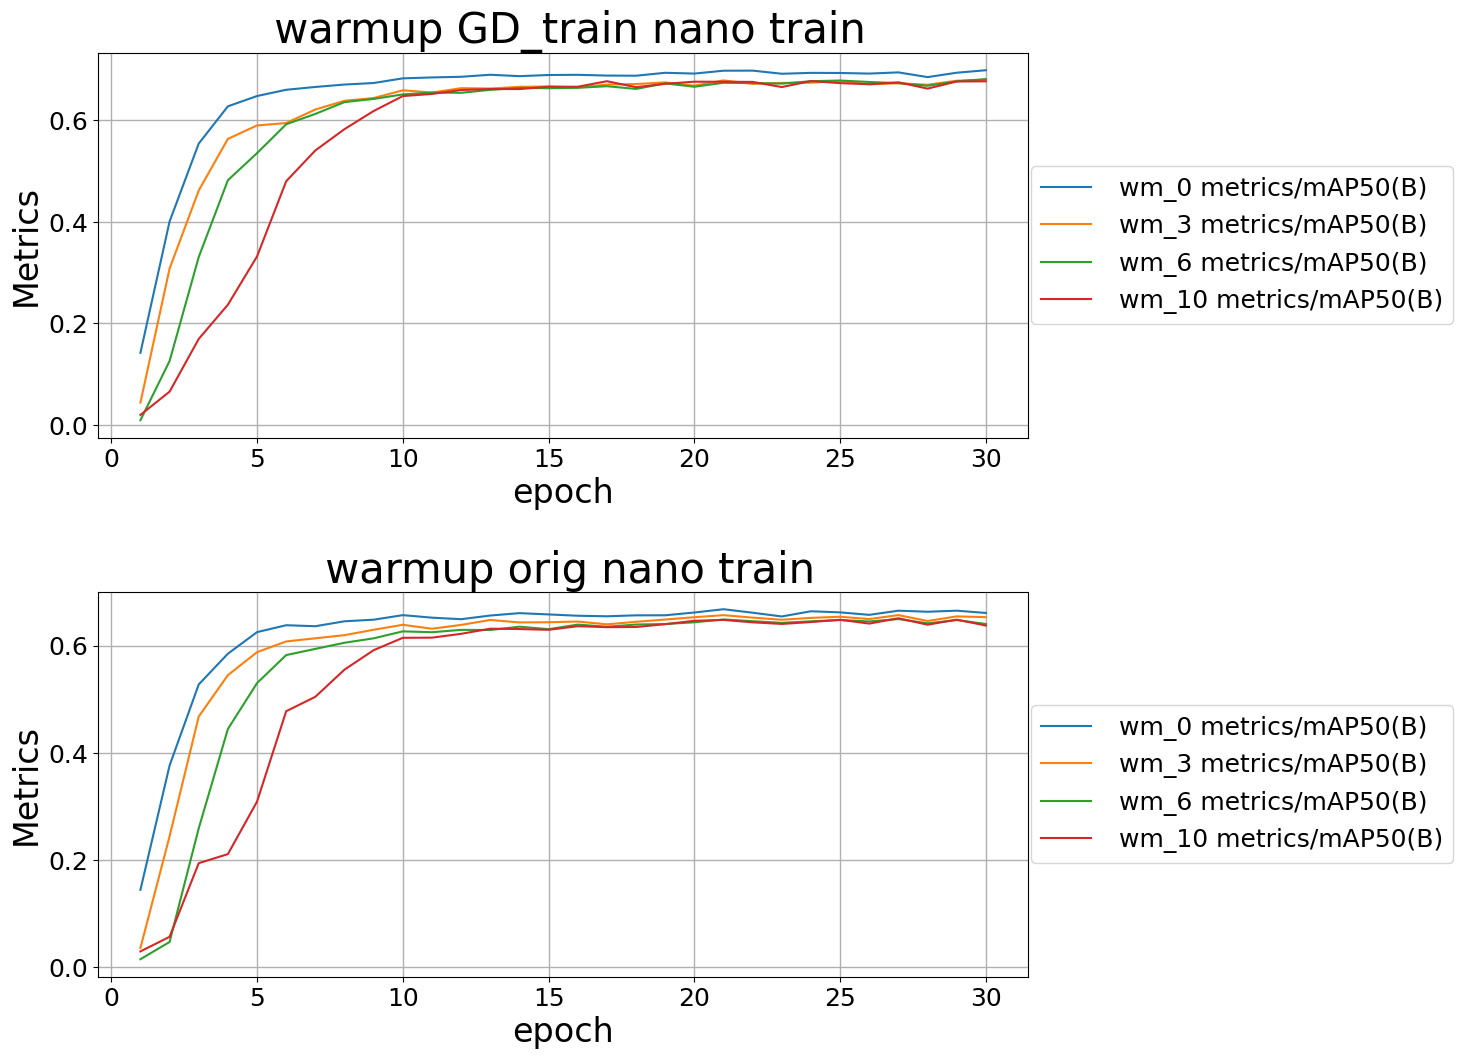

In [23]:
experiments = ['warmup']
training_data = ['GD_train','GD_train_val','orig']
models = ['nano', 'small']
warmup = ['wm_0', 'wm_3', 'wm_6', 'wm_10']
data_split = ['train', 'test']
# metrics = ['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
#        'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
#        'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
#        'lr/pg0', 'lr/pg1', 'lr/pg2']

query = (
    (['warmup'], 0), 
    (['GD_train', 'orig'], 0),
    (['nano'], 0),
    (['wm_0', 'wm_3', 'wm_6', 'wm_10'], 1),
    (['train'], 0)
)

res = get_plot_data(experiments_settings, query)
res[0]

m_config = [
    # (get_metric_df, 'metrics/mAP50-95(B)','plot'),
    (get_metric_df, 'metrics/mAP50(B)','plot'),
    ]

plot_results_metrics(res[1], m_config, dim = (12,6))



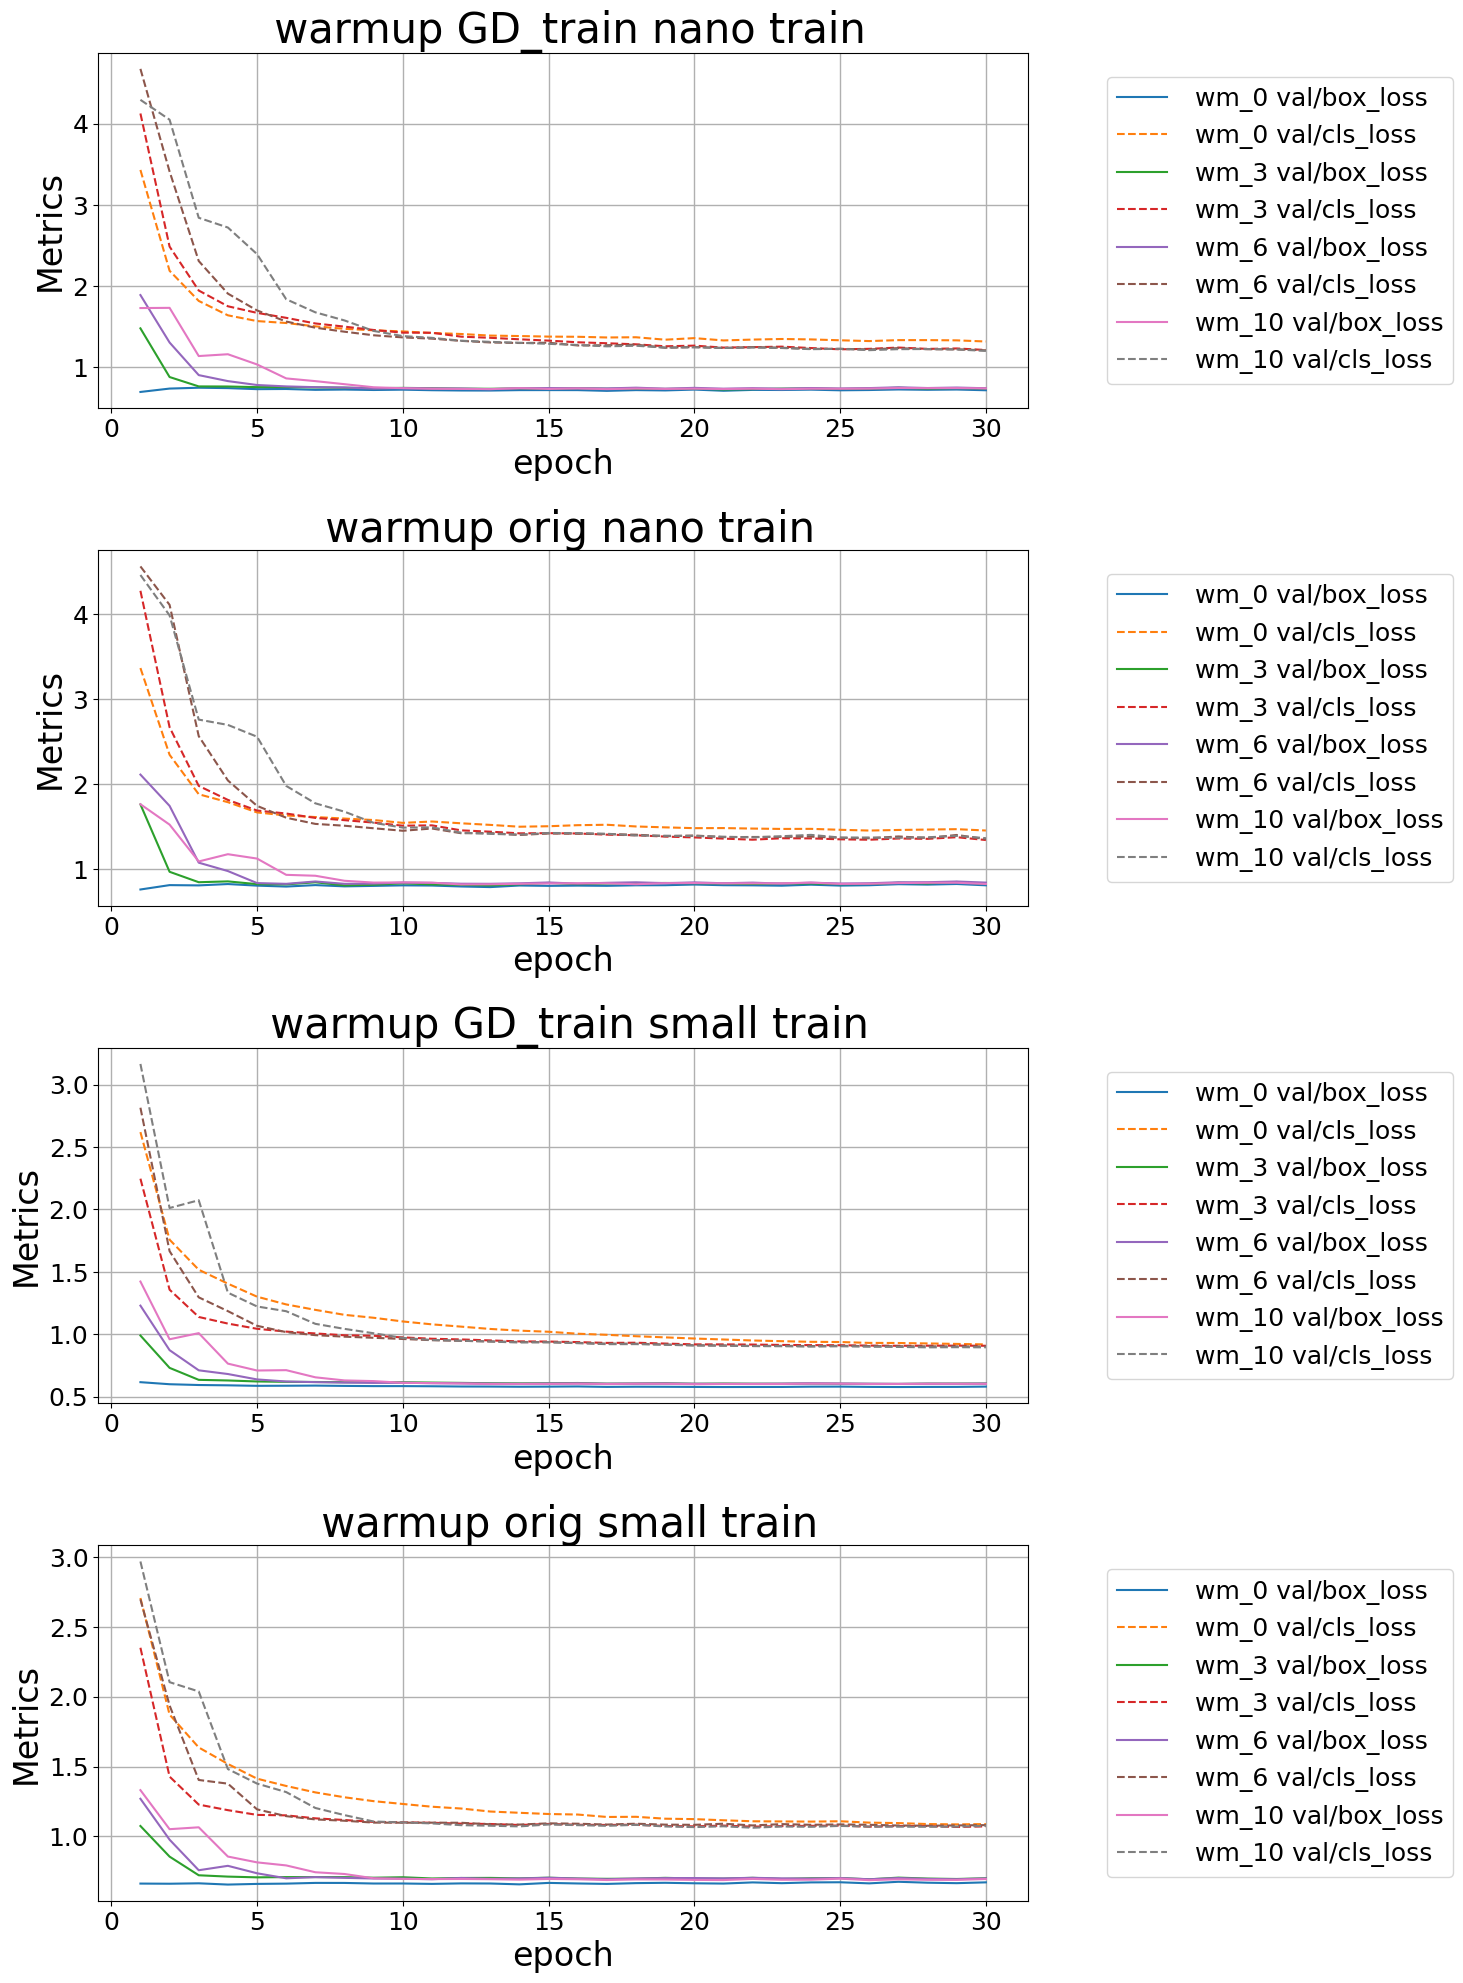

In [16]:
query = (
    (['warmup'], 0), 
    (['GD_train', 'orig'], 0),
    (['nano', 'small'], 0),
    (['wm_0', 'wm_3', 'wm_6', 'wm_10'], 1),
    (['train'], 0)
)

res = get_plot_data(experiments_settings, query)
res[0]

m_config = [
    (get_metric_df, 'val/box_loss','plot'),
    (get_metric_df, 'val/cls_loss','plot'),
    ]

plot_results_metrics(res[1], m_config, dim = (12,6))

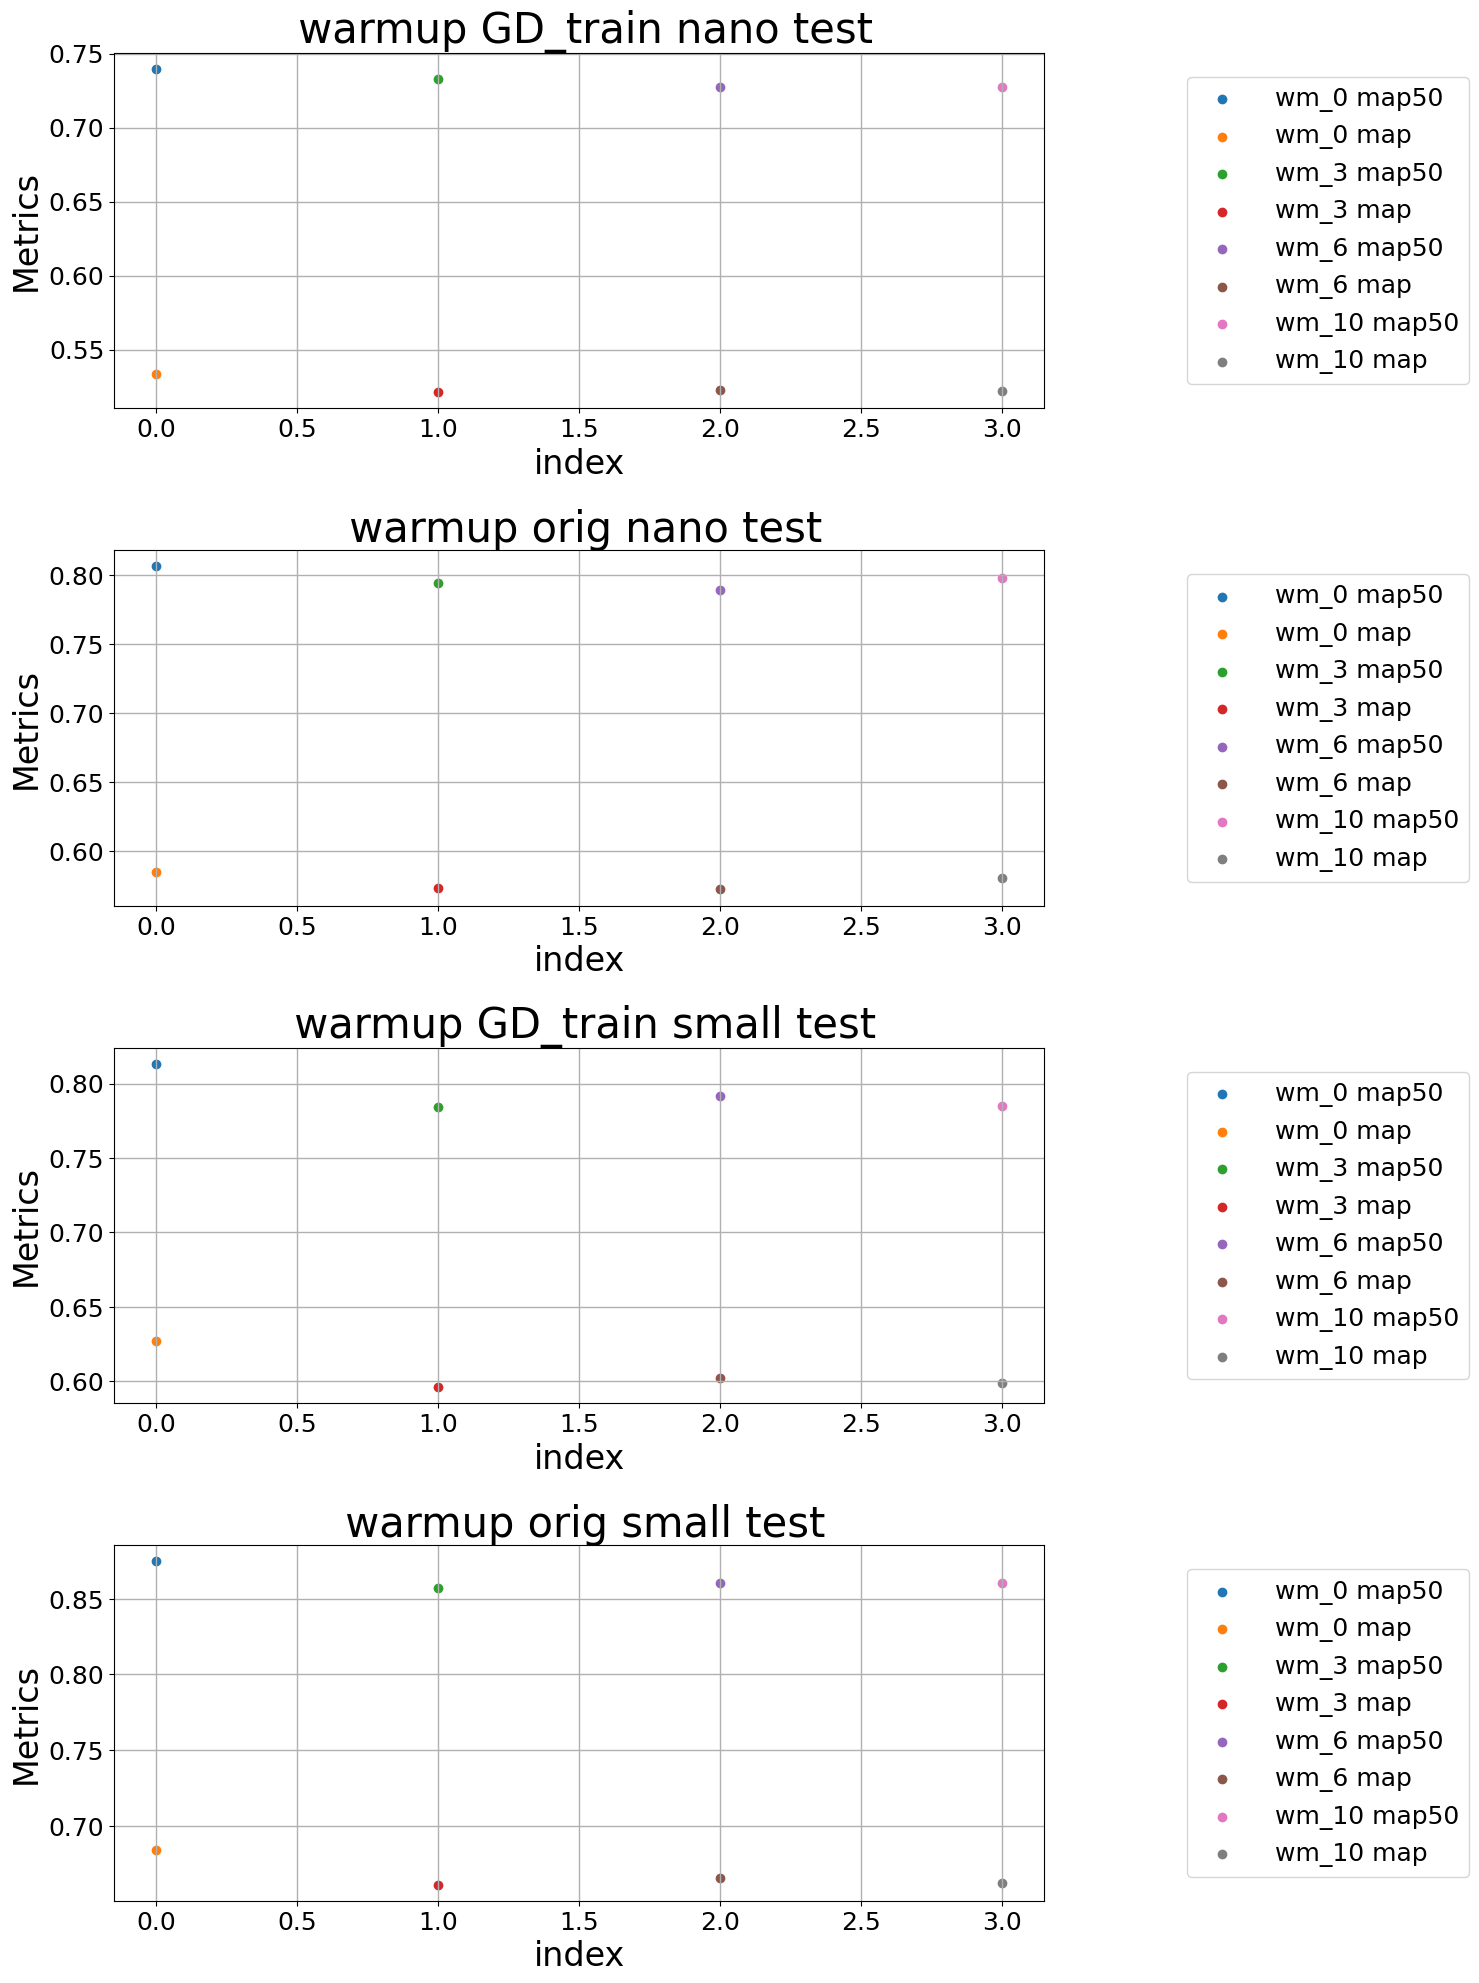

In [17]:
query = (
    (['warmup'], 0), 
    (['GD_train', 'orig'], 0),
    (['nano', 'small'], 0),
    (['wm_0', 'wm_3', 'wm_6', 'wm_10'], 1),
    (['test'], 0)
)

res = get_plot_data(experiments_settings, query)
res[0]

m_config = [
    (get_pickle, 'map50','scatter'),
    (get_pickle, 'map','scatter'),
    ]

plot_results_metrics(res[1], m_config, dim = (12,6))

In [5]:
# ../runs/freezing/GD_train/nano/no_freeze/test/results.pickle
def prepare_df(path):
    df = pd.read_csv(path)
    df.columns = [x.split(' ')[-1] for x in df.columns]
    return df   

def get_single_data(path):
    if path.endswith('.csv'):
        data = prepare_df(path)
    else:
        data = pickle.load(open(path, "rb"))
    return data

def get_mAP_from_pickle(pickle_data, metric_atr):
    metric = getattr(pickle_data, metric_atr)
    return metric

In [22]:
def plot_map50(data1, data2, x_ticks, x_label,y_label, title, label1, label2, fig = None, ax=None, y_lim=None):
    if ax is None or fig is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

    colors = [
        "#b30000",
        "#4421af"
    ]
    
    for data, label, color in zip([data1, data2],[label1, label2], colors):
        ax.plot( x_ticks, data, label = label, color=color, marker='o', markersize=10)

    if y_lim is not None:
        ax.set_ylim(*y_lim)

    ax.set_xlabel(x_label, fontsize=16)
    ax.legend(fontsize=14, loc='lower right')
    ax.grid(which="major", linewidth=1)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.set_xticklabels(x_ticks)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_ylabel(y_label, fontsize=16)
    ax.set_title(title, fontsize=18, pad = 20)

    return fig, ax

In [23]:
!ls ../runs/warmup/GD_train/nano

wm_0  wm_10  wm_3  wm_6


In [28]:
models = ['nano', 'small']

dataset_names = ['original dataset', 'pseudo labeled dataset']
dataset_paths = ['orig', 'GD_train_val']

metric_names = ['mAP 50', 'mAP 50-95']
metric_atrs = ['map50','map']

warmup_names = ['0', '3', '6','10']
warmup_paths = ['wm_0', 'wm_3', 'wm_6','wm_10']

columns = [f'{wm} {map_metric}' for wm in warmup_names for map_metric in metric_names ]
indexes = [f'{model} {d_name}' for model in models for d_name in dataset_names]

df = pd.DataFrame(
    columns=columns,
    index=indexes
)

for model in models:
    for d_path, d_name in zip(dataset_paths, dataset_names):
        for map_name, map_atr in zip(metric_names, metric_atrs):
            for wm_name, wm_path in zip(warmup_names, warmup_paths):
                
                full_path = f'../runs/warmup/{d_path}/{model}/{wm_path}/test/results.pickle'

                res = get_mAP_from_pickle(get_single_data(full_path), map_atr)
                df.loc[f'{model} {d_name}',f'{wm_name} {map_name}'] = res

df = df.astype('float32')
df

,0 mAP 50,0 mAP 50-95,3 mAP 50,3 mAP 50-95,6 mAP 50,6 mAP 50-95,10 mAP 50,10 mAP 50-95
nano original dataset,0.806434,0.584451,0.794187,0.573486,0.788978,0.572058,0.797698,0.580626
nano pseudo labeled dataset,0.739631,0.533343,0.732893,0.521353,0.727610,0.522557,0.727344,0.522141
small original dataset,0.874601,0.684168,0.857256,0.661326,0.860419,0.665463,0.860181,0.662680
small pseudo labeled dataset,0.813144,0.626990,0.783893,0.596083,0.791547,0.602009,0.784919,0.598528


In [25]:
!rm -rf {save_dir}

/tmp/ipykernel_13492/1138078660.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks)
/tmp/ipykernel_13492/1138078660.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks)
/tmp/ipykernel_13492/1138078660.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks)


mAP 50 YOLO nano model trained with different warmup epochs.png
mAP 50-95 YOLO nano model trained with different warmup epochs.png
mAP 50 YOLO small model trained with different warmup epochs.png


/tmp/ipykernel_13492/1138078660.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks)


mAP 50-95 YOLO small model trained with different warmup epochs.png


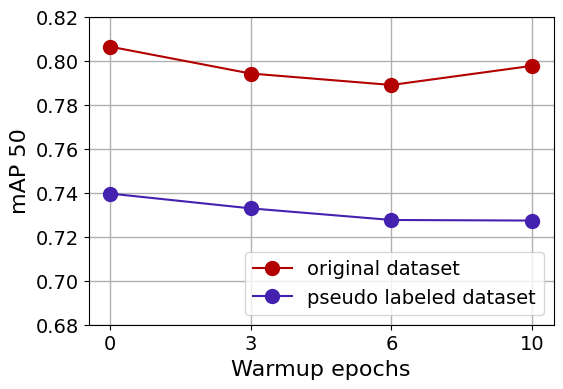

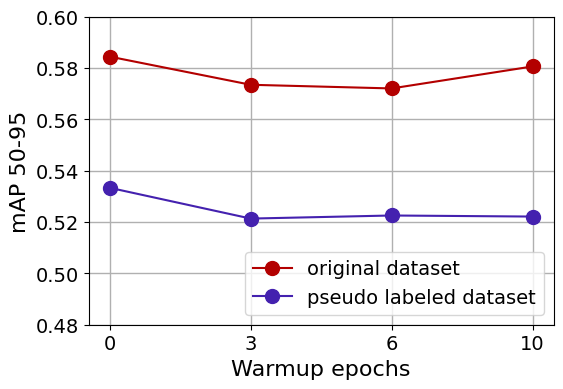

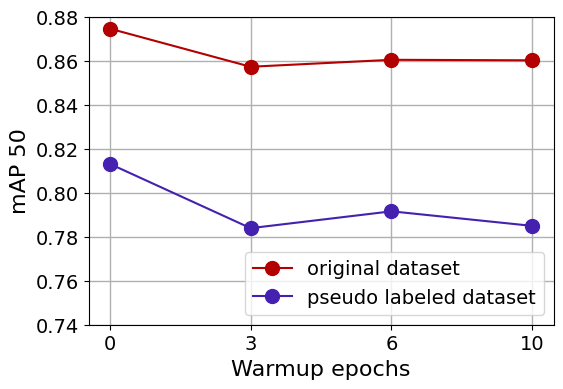

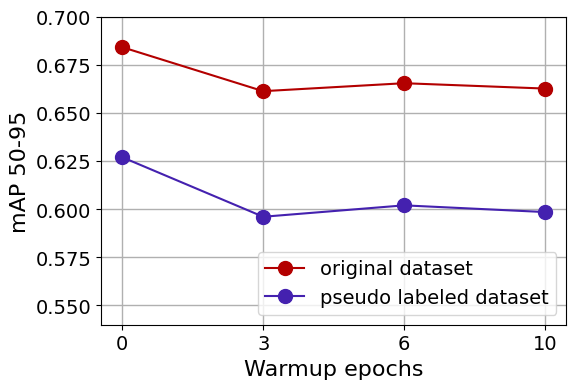

In [26]:
save_dir = 'outputs/warmup'
os.makedirs(save_dir)

y_lims = [(0.68,0.82), (0.48,0.6), (0.74,0.88), (0.54,0.70)]
y_lim_index = 0
y_ticks = []

for model in models:
    for map_name, map_atr in zip(metric_names, metric_atrs):
        # for d_path, d_name in zip(dataset_paths, dataset_names):
        #     pass
        data_1 = df.loc[f'{model} {dataset_names[0]}', 
                           [f'{wm} {map_name}' for wm in warmup_names]]
        data_2 = df.loc[f'{model} {dataset_names[1]}', 
                           [f'{wm} {map_name}' for wm in warmup_names]]
        
        label_1 = dataset_names[0]
        label_2 = dataset_names[1]

        fig, _ = plot_map50(data1=data_1, data2=data_2, x_ticks=warmup_names, x_label='Warmup epochs',
                   y_label = map_name, title='', label1=label_1, label2=label_2, y_lim=y_lims[y_lim_index])
        
        y_lim_index+=1
        
        file_name = f'{map_name} YOLO {model} model trained with different warmup epochs.png'
        print(file_name)
        fig.savefig(f'{save_dir}/{file_name}', bbox_inches = 'tight')


In [27]:
df_3 = df.round(3)
df_3.to_csv(f'{save_dir}/data.csv')